## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt

---

In [2]:
random_seed = 43
np.random.seed(random_seed)

## Task 1 implementation

### environ constants

In [3]:
slot_machine_num = 100
time_period = 1000

In [4]:
slot_machine_expect = np.random.randn(slot_machine_num)
slot_machine_var = np.array([1] * slot_machine_num)

get_reward = lambda i: np.random.normal(slot_machine_expect[i], slot_machine_var[i])

In [30]:
greedy_policy_init = 1. / slot_machine_num
eps_greedy_const = 0.01
eps_softmax_const = 16
eps_usb = 0.5

### Greedy policy

In [6]:
reward_sum = np.array([0.] * slot_machine_num)
play_count = np.array([0] * slot_machine_num)

grst_reward_machine_set_mask = np.array([True] * slot_machine_num)
machine_policy = np.array([greedy_policy_init] * slot_machine_num)
step_av_reward = []

for t in range(time_period):
    machine_policy.fill(0)
    machine_policy[grst_reward_machine_set_mask] = 1. / (grst_reward_machine_set_mask.sum())
    
    winner = np.random.choice(range(slot_machine_num), 1, p=machine_policy)[0]
    play_count[winner] += 1
    reward_sum[winner] += get_reward(winner)
    
    av_reward = np.array([0.] * slot_machine_num)
    av_reward[play_count != 0] = reward_sum[play_count != 0] * 1. / play_count[play_count != 0]
    grst_reward_machine_set_mask = av_reward == av_reward.max()
    
    step_av_reward.append((machine_policy * slot_machine_expect).sum())

_Рассмотрим "обученную" стратегию для игры:_

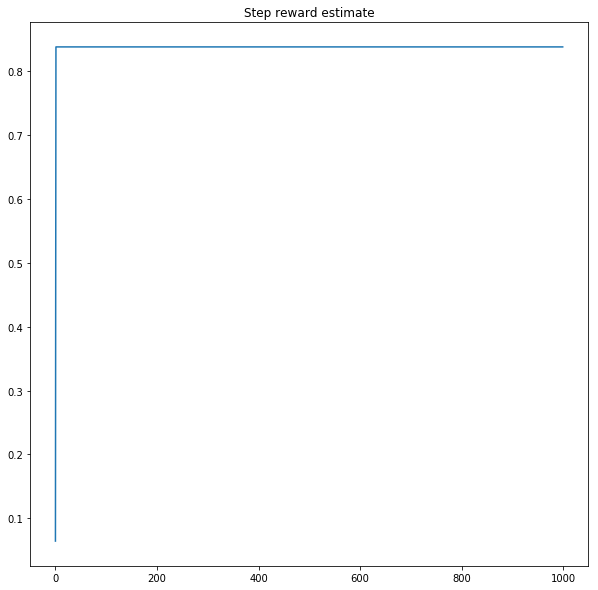

In [7]:
plt.figure(figsize=(10, 10))
plt.title('Step reward estimate')
plt.plot(range(time_period), step_av_reward)
plt.show()

In [8]:
av_reward = np.array([0.] * slot_machine_num)
av_reward[play_count != 0] = reward_sum[play_count != 0] * 1. / play_count[play_count != 0]

print("Не хватило до оптимальной стратегии {}\n".format(time_period * slot_machine_expect.max() - reward_sum.sum()))
print("Дискретное распределение стратегии: \n{}\n".format(machine_policy))
print("Единственный автомат, в который мы будем играть: {}\n".format(machine_policy.argmax()))
print("Средние выигрыши к этому моменту: \n{}\n".format(list(zip(range(slot_machine_num), av_reward))))
print("Мат. ожидания выигрышей (по возрастанию) \n{}\n".format(list(zip(slot_machine_expect.argsort(), sorted(slot_machine_expect)))))

Не хватило до оптимальной стратегии 1417.631691273951

Дискретное распределение стратегии: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]

Единственный автомат, в который мы будем играть: 29

Средние выигрыши к этому моменту: 
[(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0), (10, 0.0), (11, 0.0), (12, 0.0), (13, 0.0), (14, 0.0), (15, 0.0), (16, 0.0), (17, 0.0), (18, 0.0), (19, 0.0), (20, 0.0), (21, 0.0), (22, 0.0), (23, 0.0), (24, 0.0), (25, 0.0), (26, 0.0), (27, 0.0), (28, 0.0), (29, 0.8486610169362404), (30, 0.0), (31, 0.0), (32, 0.0), (33, 0.0), (34, 0.0), (35, 0.0), (36, 0.0), (37, 0.0), (38, 0.0), (39, 0.0), (40, 0.0), (41, 0.0), (42, 0.0), (43, 0.0), (44, 0.0), (45, 0.0), (

_Наблюдаем, что наш жадный подход выбрал один единственный автомат, в который он по его мнению рекомендует нам играть._

_Проанализируем подробнее состояние среды и метаданные нашей стратегии. Видим, что жадный алгоритм нашел не статистически лучший автомат._

_Отличительной чертой данного подхода является тот факт, что большая часть автоматов даже не была опробована. Это связано с тем, что как только один из автоматов даст неотрицательный выигрыш, для нашего алгоритма этот автомат станет оптимальный до тех пор, пока он показывает в среднем положительный результат, не трудно понять, что в этом случае мы исключаем из рассмотрения множество более оптимальных для игры автоматов. Исправить эту ситуацию позволит придание ненулевой вероятности в стратегии для автоматов, которые на текущей итерации не имеют лучшей оценки на мат. ожидание_

_Инициализацией для стратегии мы положили - "равномерное" распределение на всех автоматах. Увеличение начальной вероятности любого автомата --- это добавление в модель некоторой априорной информации о значимости этого автомата (по условию среды, этой информации у нас нет). Т.е. если мы изначально будем выбирать автоматы не равнозначно, мы перевзвесим какие-то из автоматов, если придадим им больщий вес или недооценим, если занизим вероятность. По этой причине было выбрано "равномерное" распределение._

### $\varepsilon$ -greedy policy

In [9]:
reward_sum = np.array([0.] * slot_machine_num)
play_count = np.array([0] * slot_machine_num)

grst_reward_machine_set_mask = np.array([True] * slot_machine_num)
machine_policy = np.array([greedy_policy_init] * slot_machine_num)

eps = eps_greedy_const
step_av_reward = []
for t in range(time_period):
    machine_policy.fill(eps / slot_machine_num)
    machine_policy[grst_reward_machine_set_mask] += (1. - eps) / (grst_reward_machine_set_mask.sum())
    
    winner = np.random.choice(range(slot_machine_num), 1, p=machine_policy)[0]
    play_count[winner] += 1
    reward_sum[winner] += get_reward(winner)
    
    av_reward = np.array([0.] * slot_machine_num)
    av_reward[play_count != 0] = reward_sum[play_count != 0] * 1. / play_count[play_count != 0]
    grst_reward_machine_set_mask = av_reward == av_reward.max()
    
    eps -= (eps / time_period)
    step_av_reward.append((machine_policy * slot_machine_expect).sum())

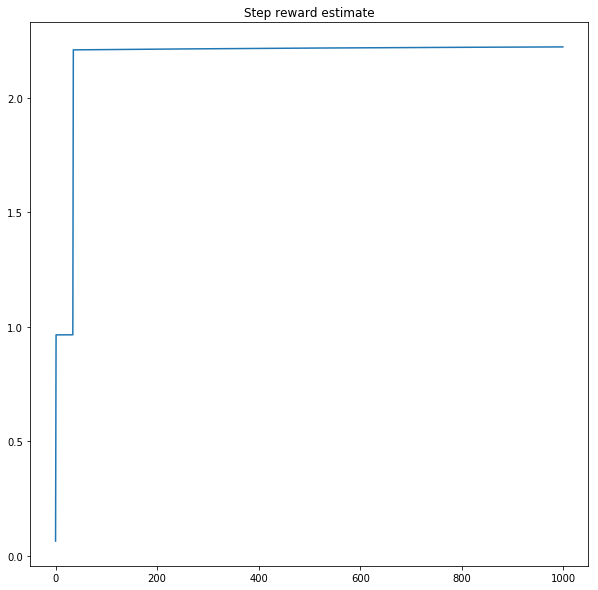

In [10]:
plt.figure(figsize=(10, 10))
plt.title('Step reward estimate')
plt.plot(range(time_period), step_av_reward)
plt.show()

In [11]:
av_reward = np.array([0.] * slot_machine_num)
av_reward[play_count != 0] = reward_sum[play_count != 0] * 1. / play_count[play_count != 0]

print("Не хватило до оптимальной стратегии {}\n".format(time_period * slot_machine_expect.max() - reward_sum.sum()))
print("Дискретное распределение стратегии: \n{}\n".format(machine_policy))
print("Единственный автомат, в который мы будем играть: {}\n".format(machine_policy.argmax()))
print("Средние выигрыши к этому моменту: \n{}\n".format(list(zip(range(slot_machine_num), av_reward))))
print("Мат. ожидания выигрышей (по возрастанию) \n{}\n".format(list(zip(slot_machine_expect.argsort(), sorted(slot_machine_expect)))))

Не хватило до оптимальной стратегии 137.55446914945514

Дискретное распределение стратегии: 
[3.68063488e-05 3.68063488e-05 3.68063488e-05 3.68063488e-05
 3.68063488e-05 3.68063488e-05 3.68063488e-05 3.68063488e-05
 3.68063488e-05 3.68063488e-05 3.68063488e-05 3.68063488e-05
 3.68063488e-05 3.68063488e-05 3.68063488e-05 3.68063488e-05
 3.68063488e-05 3.68063488e-05 3.68063488e-05 3.68063488e-05
 3.68063488e-05 3.68063488e-05 9.96356171e-01 3.68063488e-05
 3.68063488e-05 3.68063488e-05 3.68063488e-05 3.68063488e-05
 3.68063488e-05 3.68063488e-05 3.68063488e-05 3.68063488e-05
 3.68063488e-05 3.68063488e-05 3.68063488e-05 3.68063488e-05
 3.68063488e-05 3.68063488e-05 3.68063488e-05 3.68063488e-05
 3.68063488e-05 3.68063488e-05 3.68063488e-05 3.68063488e-05
 3.68063488e-05 3.68063488e-05 3.68063488e-05 3.68063488e-05
 3.68063488e-05 3.68063488e-05 3.68063488e-05 3.68063488e-05
 3.68063488e-05 3.68063488e-05 3.68063488e-05 3.68063488e-05
 3.68063488e-05 3.68063488e-05 3.68063488e-05 3.68063

_Сразу заметим, что новый более умный подход находит практически оптимальный статистически автомат для игры. Более того, итоговый выигрыш значительно ближе к оптимальному в отличие от наивной жадной стратегии._

_Увеличение гиперпараметра алгоритма будет приводить к более частому исследованию распределений автоматов (корректировки оценок на мат. ожидания выигрыша автомата). Это позволяет нам не застревать на статистически неотрицательных автоматах. Положив $\varepsilon$ за ноль, мы получим наивный жадник из предыдущего пункта._

_Т.к. число ходов у нас ограничено, мы не можем себе позволить (хотим много денег) исследовать все ходы, поэтому было бы разумно пропорционально понижать вероятность исследования на каждом шаге, т.к. с каждым ходом растет наша уверенность в распределениях автоматов. Например, можно за предоставленное нам количество ходов равномерно сводить к нулю вероятность исследования от начальной к около нулевому значению._

### Softmax

In [12]:
reward_sum = np.array([2.] * slot_machine_num)
play_count = np.array([1] * slot_machine_num)

machine_policy = np.array([greedy_policy_init] * slot_machine_num)

e = eps_softmax_const
step_av_reward = []
for t in range(time_period):
    eps = e * 1. / (t + 1)
    av_reward = np.array([0.] * slot_machine_num)
    av_reward[play_count != 0] = reward_sum[play_count != 0] * 1. / play_count[play_count != 0]
    
    compl_prob = np.exp(av_reward / eps).sum()
    machine_policy = np.exp(av_reward / eps) / compl_prob
    
    winner = np.random.choice(range(slot_machine_num), 1, p=machine_policy)[0]
    play_count[winner] += 1
    reward_sum[winner] += get_reward(winner)
    
    #eps -= (eps / time_period)
    step_av_reward.append((machine_policy * slot_machine_expect).sum())

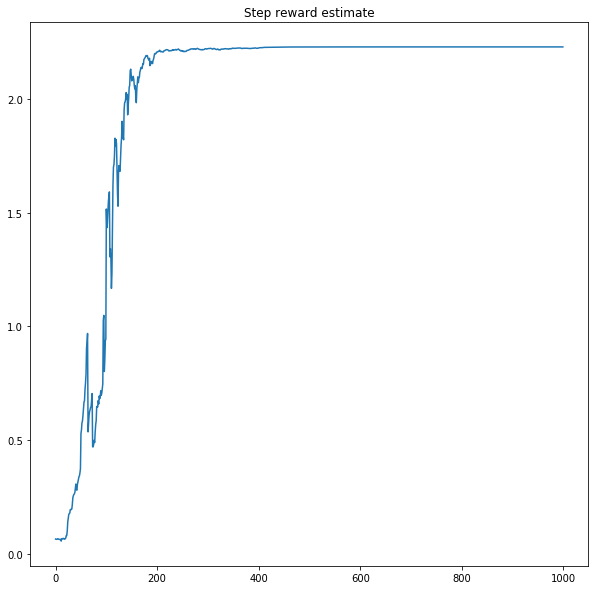

In [13]:
plt.figure(figsize=(10, 10))
plt.title('Step reward estimate')
plt.plot(range(time_period), step_av_reward)
plt.show()

In [14]:
av_reward = np.array([0.] * slot_machine_num)
av_reward[play_count != 0] = reward_sum[play_count != 0] * 1. / play_count[play_count != 0]

print("Не хватило до оптимальной стратегии {}\n".format(time_period * slot_machine_expect.max() - reward_sum.sum()))
print("Дискретное распределение стратегии: \n{}\n".format(machine_policy))
print("Единственный автомат, в который мы будем играть: {}\n".format(machine_policy.argmax()))
print("Средние выигрыши к этому моменту: \n{}\n".format(list(zip(range(slot_machine_num), av_reward))))
print("Мат. ожидания выигрышей (по возрастанию) \n{}\n".format(list(zip(slot_machine_expect.argsort(), sorted(slot_machine_expect)))))

Не хватило до оптимальной стратегии 7.3956230688095275

Дискретное распределение стратегии: 
[4.10216265e-32 4.22734690e-79 4.45670522e-38 1.58748060e-46
 4.29438784e-32 1.42139384e-44 1.14960935e-18 1.39977754e-08
 7.60602789e-43 9.68376788e-53 3.51717829e-09 4.63668105e-25
 1.01820272e-60 3.51717829e-09 5.72817679e-51 2.76762089e-37
 3.51717829e-09 1.48933255e-51 2.03981182e-33 2.10651271e-29
 1.15323803e-49 1.43735071e-31 9.99999793e-01 2.09628623e-19
 1.88294695e-32 1.04407718e-37 4.00935845e-53 2.81357638e-37
 1.31622380e-27 6.10315614e-37 4.75020095e-62 7.99668811e-30
 9.03129270e-69 2.64775818e-24 1.23683276e-44 3.04501935e-22
 1.47852625e-75 1.11883631e-20 8.33950997e-20 9.07204605e-28
 1.47568295e-24 2.49220803e-13 4.25998937e-24 3.62097534e-21
 3.18023289e-43 6.77611725e-20 3.51717829e-09 1.02178092e-22
 4.88939759e-59 4.29016959e-21 8.69241183e-61 1.77105450e-75
 1.35973208e-45 2.81371815e-35 5.76888579e-79 3.56820101e-34
 7.55896366e-24 2.07818300e-20 2.05206834e-69 9.52179

In [15]:
cv_results = {}

In [16]:
cv_results = {}
for e in range(10, 150):
    print("{} iter started".format(e))
    cv = []
    for it in range(10):
        reward_sum = np.array([0.] * slot_machine_num)
        play_count = np.array([0] * slot_machine_num)

        machine_policy = np.array([greedy_policy_init] * slot_machine_num)

        step_av_reward = []
        for t in range(time_period):
            eps = e * 1. / (t + 1)
            av_reward = np.array([0.] * slot_machine_num)
            av_reward[play_count != 0] = reward_sum[play_count != 0] * 1. / play_count[play_count != 0]

            compl_prob = np.exp(av_reward / eps).sum()
            machine_policy = np.exp(av_reward / eps) / compl_prob

            winner = np.random.choice(range(slot_machine_num), 1, p=machine_policy)[0]
            play_count[winner] += 1
            reward_sum[winner] += get_reward(winner)

            #eps -= (eps / time_period)
            step_av_reward.append((machine_policy * slot_machine_expect).sum())

        cv.append(time_period * slot_machine_expect.max() - reward_sum.sum())
    cv = np.array(cv).mean()
    cv_results[e] = cv

10 iter started
11 iter started
12 iter started
13 iter started
14 iter started
15 iter started
16 iter started
17 iter started
18 iter started
19 iter started
20 iter started
21 iter started
22 iter started
23 iter started
24 iter started
25 iter started
26 iter started
27 iter started
28 iter started
29 iter started
30 iter started
31 iter started
32 iter started
33 iter started
34 iter started
35 iter started
36 iter started
37 iter started
38 iter started
39 iter started
40 iter started
41 iter started
42 iter started
43 iter started
44 iter started
45 iter started
46 iter started
47 iter started
48 iter started
49 iter started
50 iter started
51 iter started
52 iter started
53 iter started
54 iter started
55 iter started
56 iter started
57 iter started
58 iter started
59 iter started
60 iter started
61 iter started
62 iter started
63 iter started
64 iter started
65 iter started
66 iter started
67 iter started
68 iter started
69 iter started
70 iter started
71 iter started
72 iter 

In [17]:
cv_results

{10: 438.54257079522375,
 11: 375.9670588614318,
 12: 327.20690967391266,
 13: 318.98947591279614,
 14: 355.69940009428365,
 15: 322.87408997684827,
 16: 190.6595049992956,
 17: 322.06832705412586,
 18: 210.84112807467372,
 19: 158.02969214271647,
 20: 376.49047264900287,
 21: 242.7824350169707,
 22: 250.53271486200043,
 23: 291.50594436041473,
 24: 387.12069017120785,
 25: 309.9039750140822,
 26: 391.76023100941643,
 27: 292.15169165275745,
 28: 284.9176247505037,
 29: 304.042870669733,
 30: 233.48212173167764,
 31: 394.1462175591459,
 32: 255.2448419056992,
 33: 294.30397980425005,
 34: 265.60361166253256,
 35: 236.68934681267882,
 36: 386.6928685572236,
 37: 314.6802794379936,
 38: 445.81110946892056,
 39: 258.6138791158678,
 40: 248.00296841349487,
 41: 255.82961718830137,
 42: 303.47130206262466,
 43: 276.5456872752735,
 44: 321.1336275472962,
 45: 246.3043024529837,
 46: 306.30587116490557,
 47: 334.0484602019325,
 48: 330.00085524377783,
 49: 299.4326097063247,
 50: 265.17185317

_Данный подход как и предыдущий является одним из способом имплементировать идею "исследования" системы. Однако в отличие от $\varepsilon$ жадника имеет существенное преимущество. Он не перевзвешивает важность (вероятность) текуще оптимального автомата на текущей итерации, у каждого автомата есть вероятность выиграть итерацию обучения, причем эта вероятность не равномерно распределена по всем автоматам, а пропорциональна текущим оценкам. Это достаточно логично, ведь мы всегда предпочтем исследователь автомат с более "вкусной" оценкой на выигрыш, чем, например, автомат оценка на которого отрицательная, для предыдущего подхода в этих автоматах разницы нет. Однако мы сталкиваемся теперь с некоторым подводным камнем, совсем неисследованные автоматы при плохих инициализациях не имеют большого веса на проверке, если проинициализировать все оценки нулями, мы опять столкнемся с эффектом некоторой кластеризации, когда все исследование концентрируется среди наиболее "удачных" автоматах, которые мы успели проверить на первых итерациях. Решить эту проблему не так уж и сложно, достаточно задать априори всем автоматам достаточно высокую оценку на выигрыш, время от времени она все равно выправится к более правдоподобной, мы себя этим не обманем, более того еще и сможем исследовать новые автоматы не концентрируясь на маленьком подмножестве._

_При стремлении гиперпараметра к нулю, мы сильнее сглаживаем текущие оценки (уравниваем между собой). При стремлении к бесконечноти, наоборот, сильнее доверяем текущим оценкам._

### UCB

In [34]:
reward_sum = np.array([0.] * slot_machine_num)
play_count = np.array([0] * slot_machine_num)

machine_policy = np.array([greedy_policy_init] * slot_machine_num)

e = eps_usb
step_av_reward = []
for t in range(time_period):
    av_reward = np.array([0.] * slot_machine_num)
    av_reward[play_count != 0] = reward_sum[play_count != 0] * 1. / play_count[play_count != 0]
    
    machine_policy = av_reward + e * np.sqrt((2 * np.log(t + 1)) / (play_count + 1e-8))
    
    winner = machine_policy.argmax()
    play_count[winner] += 1
    reward_sum[winner] += get_reward(winner)
    
    #eps -= (eps / time_period)
    step_av_reward.append((machine_policy * slot_machine_expect).sum())

In [33]:
av_reward = np.array([0.] * slot_machine_num)
av_reward[play_count != 0] = reward_sum[play_count != 0] * 1. / play_count[play_count != 0]

print("Не хватило до оптимальной стратегии {}\n".format(time_period * slot_machine_expect.max() - reward_sum.sum()))
print("Дискретное распределение стратегии: \n{}\n".format(machine_policy))
print("Единственный автомат, в который мы будем играть: {}\n".format(machine_policy.argmax()))
print("Средние выигрыши к этому моменту: \n{}\n".format(list(zip(range(slot_machine_num), av_reward))))
print("Мат. ожидания выигрышей (по возрастанию) \n{}\n".format(list(zip(slot_machine_expect.argsort(), sorted(slot_machine_expect)))))

Не хватило до оптимальной стратегии 273.9849475269709

Дискретное распределение стратегии: 
[ 0.97704953 -0.08372585  0.903239    2.3924385   2.31635816  1.9302266
  1.79586593  2.37327507  2.33641873  1.83440601  1.58350648  1.38884006
  1.41556646  2.35068382  1.32424415  0.59678463  2.35372076  0.94288322
  1.19618523 -1.13655683  1.00931108  1.25821387  1.97858079  2.23993291
  1.33642339  2.15903702  2.08795147  1.92017149  2.03080547  2.0596717
 -0.08240631  1.78288396  1.94332475  1.71130802  1.50234323  2.36035521
 -0.81572935  2.21386126  0.52484203  2.28776976  2.40302939  2.13255367
  2.06059592  2.40679505  0.36980121  1.22590996  1.72930102  2.08688622
 -0.36394264  2.38450329 -0.13517491  0.26889402  1.8763567   1.54730015
 -0.00708704  2.32265799  0.93443338  2.30165813  0.24505436  2.14840423
  1.08656967  1.80194499  1.45010976  1.7557148  -0.07729749  1.48091166
  1.86558116 -0.20664608  2.12928595  2.21791071  0.10991004  0.76755601
  2.18397948  1.60556    -0.319472

_Данный подход имеет то же преимущество перед эпсилон жадником, что и softmax, поэтому данный подход лучше.
По сравнению с softmax в этом подходе мы имеем неявную зависимость от точности нашей оценки (число проб автомата), что дает нам явное преимущество, т.к. в softmax мы можем один раз очень неудачно запустить автомат и потом полагать, что он плохой и исследовать его мы не будем. Это преимущество не такое высокое, т.к. softmax умеет сглаживать оценки за некоторое число итераций. Однако данный метод имеет ненормированную стратегию, что будет влиять негативно на исследование. Поэтому я бы отдал свое предпочтение softmax._

_При стремлении гиперпараметра к нулю, мы больше доверяем текущим оценкам и меньше исследуем, при стремлении к бесконечности наоборот._

### Gradient policy

In [64]:
reward_sum = np.array([0.] * slot_machine_num)
play_count = np.array([0] * slot_machine_num)

smoth_reward = np.array([0] * slot_machine_num)
probs = np.array([0] * slot_machine_num)

machine_policy = np.array([greedy_policy_init] * slot_machine_num)

alf = 0.9
lmd = 1
step_av_reward = []
for t in range(time_period):
    winner = np.random.choice(range(slot_machine_num), 1, p=machine_policy)[0]
    play_count[winner] += 1
    reward = get_reward(winner)
    reward_sum[winner] += reward
    smoth_reward = smoth_reward + alf * (reward - smoth_reward)
  
    winner_prb = probs[winner]
    probs = probs - lmd * (reward - smoth_reward) * machine_policy
    probs[winner] = winner_prb + lmd * (reward - smoth_reward[winner]) * (1 - machine_policy[winner])
    
    machine_policy = np.exp(probs) / (np.exp(probs).sum())
   
    step_av_reward.append((machine_policy * slot_machine_expect).sum())

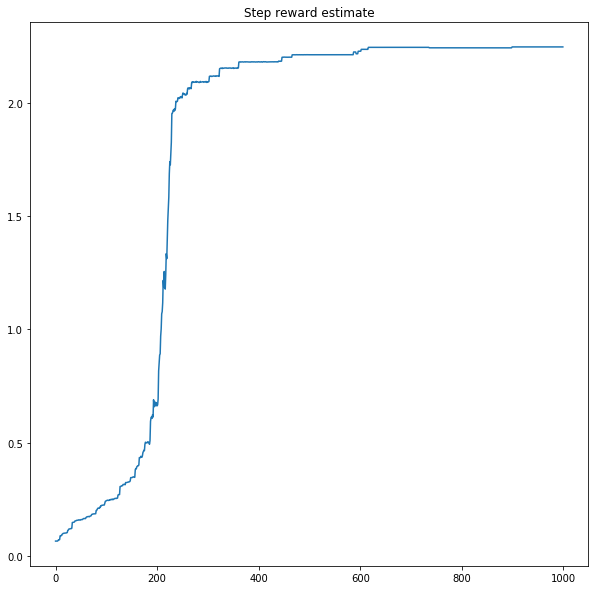

In [65]:
plt.figure(figsize=(10, 10))
plt.title('Step reward estimate')
plt.plot(range(time_period), step_av_reward)
plt.show()

In [66]:
av_reward = np.array([0.] * slot_machine_num)
av_reward[play_count != 0] = reward_sum[play_count != 0] * 1. / play_count[play_count != 0]

print("Не хватило до оптимальной стратегии {}\n".format(time_period * slot_machine_expect.max() - reward_sum.sum()))
print("Дискретное распределение стратегии: \n{}\n".format(machine_policy))
print("Единственный автомат, в который мы будем играть: {}\n".format(machine_policy.argmax()))
print("Средние выигрыши к этому моменту: \n{}\n".format(list(zip(range(slot_machine_num), av_reward))))
print("Мат. ожидания выигрышей (по возрастанию) \n{}\n".format(list(zip(slot_machine_expect.argsort(), sorted(slot_machine_expect)))))

Не хватило до оптимальной стратегии 475.2944587847678

Дискретное распределение стратегии: 
[1.46976560e-04 5.84455952e-05 9.10108652e-05 9.95291963e-05
 1.26162256e-04 6.79854616e-05 5.22356732e-05 1.65544229e-04
 2.18660529e-04 9.95291963e-05 8.76895778e-05 4.56626803e-05
 7.39698528e-05 7.23127629e-05 8.75252417e-05 6.64151452e-05
 1.70003338e-04 8.98475981e-05 7.06708149e-05 8.35700977e-05
 8.05292989e-05 6.38047888e-05 9.95291963e-05 8.79854567e-05
 9.16957041e-05 8.50497053e-05 6.72216442e-05 7.91131692e-05
 9.42829448e-05 9.88665437e-05 9.01868512e-05 1.03842528e-04
 7.97618774e-05 6.72130309e-05 5.02632487e-05 1.45676757e-04
 5.27457714e-05 1.38854915e-04 4.72412203e-05 1.69012778e-04
 8.22140671e-05 1.90855924e-04 2.09645059e-04 9.90210484e-01
 6.53312904e-05 9.33921872e-05 8.72217990e-05 8.12187857e-05
 7.75645518e-05 8.19293356e-05 9.28963175e-05 8.22794985e-05
 8.15831796e-05 7.44098102e-05 8.76311067e-05 7.95994997e-05
 1.11945803e-04 1.41403256e-04 6.33922004e-05 4.634460

### Conclusion

_Для нашей модели у нас осталось два финалиста (по аналогичным причинам grad. policy выигрывает выпавших после softmax конкурсантов): softmax и gradient policy. Gradient policy мощный подход к решению задач из исходного семейства, обладающий теми же преимуществами, что и softmax только имеет несколько своих фичей, которые излишни в контексте в контексте исходной задачи, поэтому стоит отдать предпочтение более простой модели: softmax_

---


## Task 2 implementation

### Problem statement exercise